In [56]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="darkgrid")

In [57]:
netflix_df = pd.read_csv('../Datasets/Netflix_Titles Dataset/netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [58]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [59]:
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [60]:
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [61]:
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [62]:
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format= 'mixed', dayfirst= False) #convert text(string) to date

#####  Understanding Date Conversion Syntax

*   **`pd.to_datetime(...)`**: This is a Pandas function that converts any column (usually text/object) into **datetime objects**. This allows us to easily extract the Year, Month, and Day for analysis.

*   **`format='mixed'`**: This argument is crucial because the dataset may contain dates in different styles (e.g., *"25-Sep-2021"* vs *"September 25, 2021"*).
    *   **Why use it?** By setting it to `'mixed'`, we tell Pandas to **automatically detect** the format for each individual row, preventing errors.

*   **`dayfirst=False`**: This specifies the order of the date.
    *   `False` means the first number is treated as the **Month** (US Style: MM/DD/YYYY).
    *   `True` would treat the first number as the **Day** (India/UK Style: DD/MM/YYYY).

In [63]:
#creating new features, year and month
netflix_df['year_added'] = netflix_df['date_added'].dt.year #extracting year from date_added
netflix_df['month_added'] = netflix_df['date_added'].dt.month #extracting month from date_added

In [64]:
netflix_df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

In [65]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre=netflix_df['listed_in'].str.split(', ')).explode('genre')

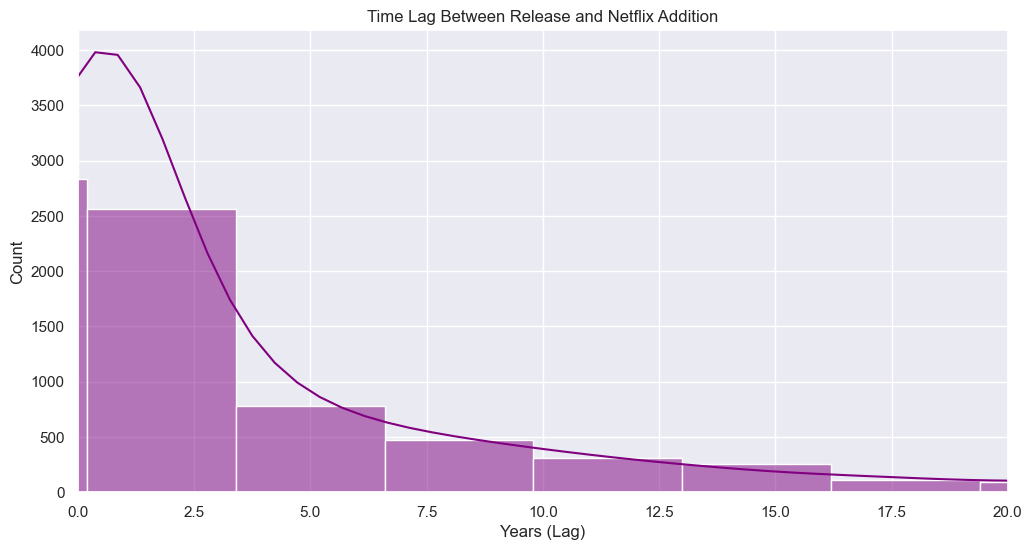

In [66]:
#How old is the content when it gets added to Netflix?
netflix_df['Content_Lag'] = netflix_df['year_added'] - netflix_df['release_year']
# Plot Content Lag
plt.figure(figsize=(12, 6))
sns.histplot(netflix_df['Content_Lag'], bins=30, kde=True, color='purple')
plt.title('Time Lag Between Release and Netflix Addition')
plt.xlim(0, 20) # Focus on the last 30 years
plt.xlabel('Years (Lag)')
plt.show()

#### Content Age at the Time of Netflix Addition

The distribution shows that most content is added to Netflix within a relatively short time after its original release.

**Key insights:**
- The majority of titles are added within **0–5 years** of release, indicating Netflix’s strong focus on **recent and relevant content**.
- The distribution is **right-skewed**, meaning older content does exist, but it is significantly less common.
- Very few titles have a content lag beyond **10 years**, suggesting that Netflix selectively acquires older titles rather than doing bulk legacy imports.
- The peak near the lower lag values highlights Netflix’s strategy of staying competitive by prioritizing **fresh content** to retain user engagement.

In [67]:
netflix_df['added_decade'] = (netflix_df['year_added'] // 5) * 5

##### How has the distribution of content ratings changed over time?

In [68]:
rating_map = {
    'TV-MA': 'Adult',
    'R': 'Adult',
    'NC-17': 'Adult',
    'TV-14': 'Teen',
    'PG-13': 'Teen',
    'TV-PG': 'Family',
    'PG': 'Family',
    'TV-G': 'Kids',
    'G': 'Kids',
    'TV-Y': 'Kids',
    'TV-Y7': 'Kids'
}

netflix_df['rating_group'] = netflix_df['rating'].map(rating_map)
netflix_df = netflix_df.dropna(subset=['rating_group'])

In [69]:
#year wise distribution of rating groups
yearly_dist = (
    netflix_df
    .groupby(['year_added', 'rating_group'])
    .size()
    .reset_index(name='count')
)

yearly_dist['percentage'] = (
    yearly_dist
    .groupby('year_added')['count']
    .transform(lambda x: x / x.sum())
)

yearly_pivot = yearly_dist.pivot(
    index='year_added',
    columns='rating_group',
    values='percentage'
).fillna(0)


In [70]:
#decade wise distribution of rating groups
decade_dist = (
    netflix_df
    .groupby(['added_decade', 'rating_group'])
    .size()
    .reset_index(name='count')
)

decade_dist['percentage'] = (
    decade_dist
    .groupby('added_decade')['count']
    .transform(lambda x: x / x.sum())
)

decade_pivot = decade_dist.pivot(
    index='added_decade',
    columns='rating_group',
    values='percentage'
).fillna(0)


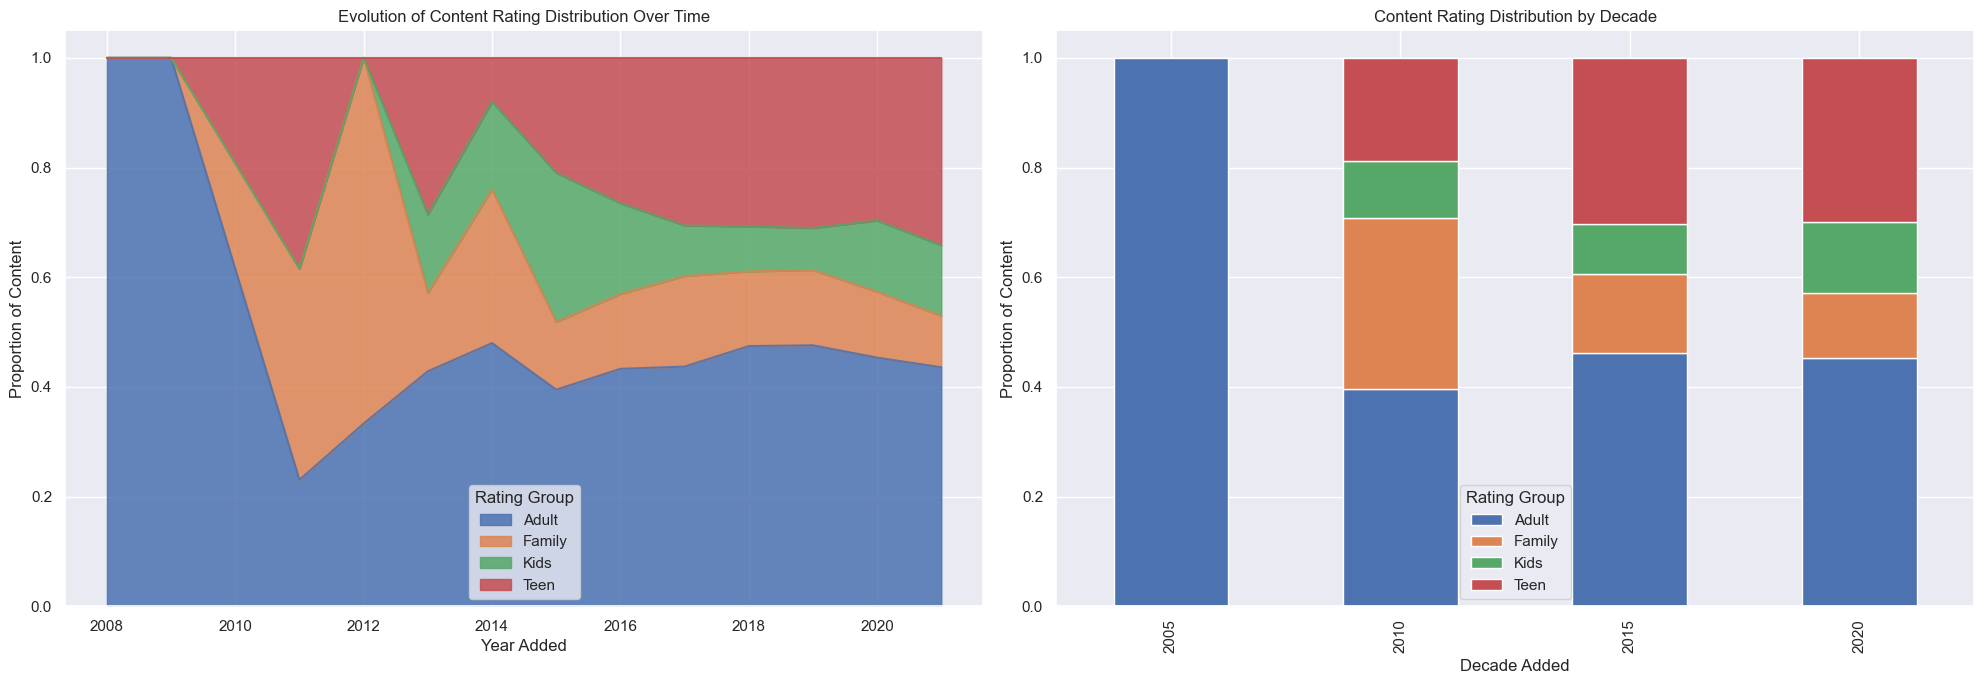

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Left: Stacked Area Chart (trend over time)
yearly_pivot.plot(
    kind='area',
    ax=axes[0],
    alpha=0.85
)
axes[0].set_title('Evolution of Content Rating Distribution Over Time')
axes[0].set_xlabel('Year Added')
axes[0].set_ylabel('Proportion of Content')
axes[0].legend(title='Rating Group')

# Right: Stacked Bar Chart (decade comparison)
decade_pivot.plot(
    kind='bar',
    stacked=True,
    ax=axes[1]
)
axes[1].set_title('Content Rating Distribution by Decade')
axes[1].set_xlabel('Decade Added')
axes[1].set_ylabel('Proportion of Content')
axes[1].legend(title='Rating Group')

plt.tight_layout()
plt.show()


#### Content Rating Trends on Netflix

The combined visualizations show a clear shift in Netflix’s content strategy over time.  
Adult-rated content increasingly dominates the platform, especially in recent years and decades.  
Family and Kids content decline proportionally, indicating a reduced focus on traditional family-oriented programming.  
Teen-rated content maintains a steady presence, bridging the gap between family and adult audiences.  
Overall, Netflix prioritizes mature, high-engagement content as part of its long-term growth strategy.


#### Is there a relationship between content age and its type (Movie vs. TV Show)?

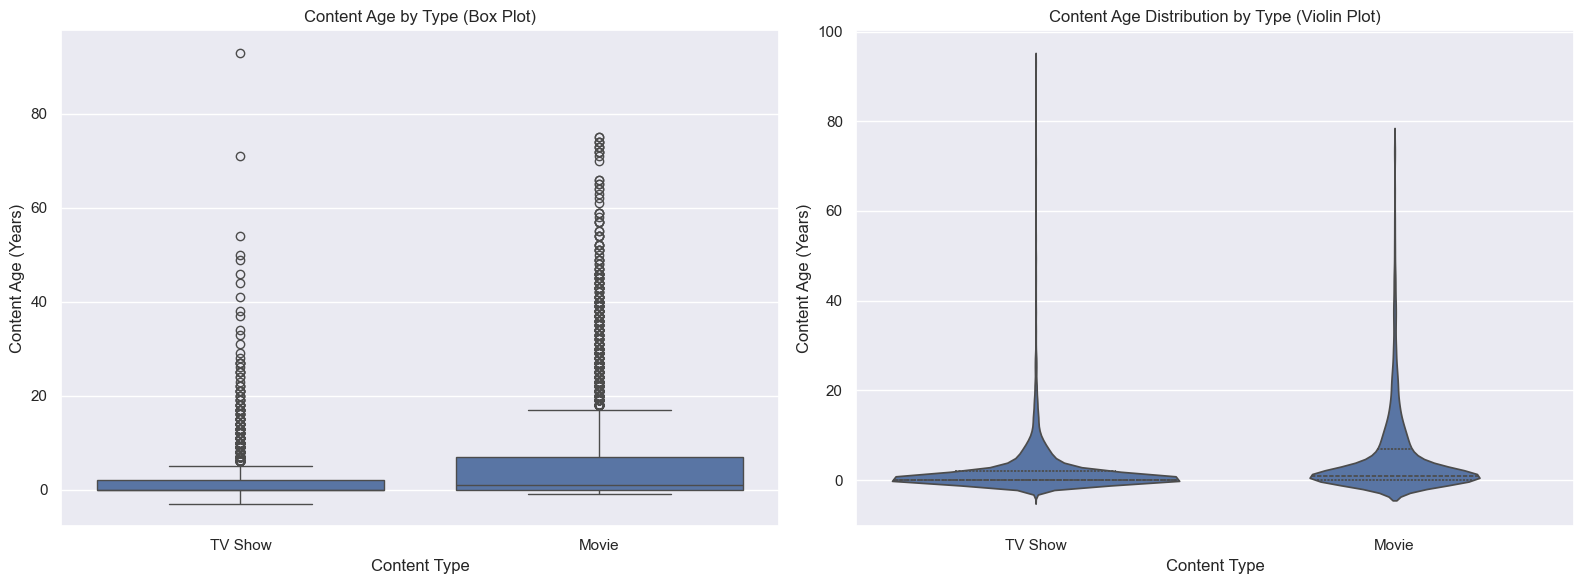

In [72]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot
sns.boxplot(
    data=netflix_df,
    x='type',
    y='Content_Lag',
    ax=axes[0]
)
axes[0].set_title('Content Age by Type (Box Plot)')
axes[0].set_xlabel('Content Type')
axes[0].set_ylabel('Content Age (Years)')

# Violin Plot
sns.violinplot(
    data=netflix_df,
    x='type',
    y='Content_Lag',
    ax=axes[1],
    inner='quartile'
)
axes[1].set_title('Content Age Distribution by Type (Violin Plot)')
axes[1].set_xlabel('Content Type')
axes[1].set_ylabel('Content Age (Years)')

plt.tight_layout()
plt.show()


### Relationship Between Content Age and Type

The box plot shows that Movies are typically added to Netflix closer to their release year, with a lower median content age.
TV Shows display a higher median and a wider spread, indicating they are often added several years after release.
The violin plot further reveals a broader and more uneven distribution for TV Shows, suggesting varied licensing and release patterns.
In contrast, Movies have a more concentrated distribution, reflecting faster acquisition cycles.
Overall, content type plays a significant role in determining how old a title is when added to Netflix.


####  Can we identify any trends in content production based on the release year vs. the year added to Netflix?

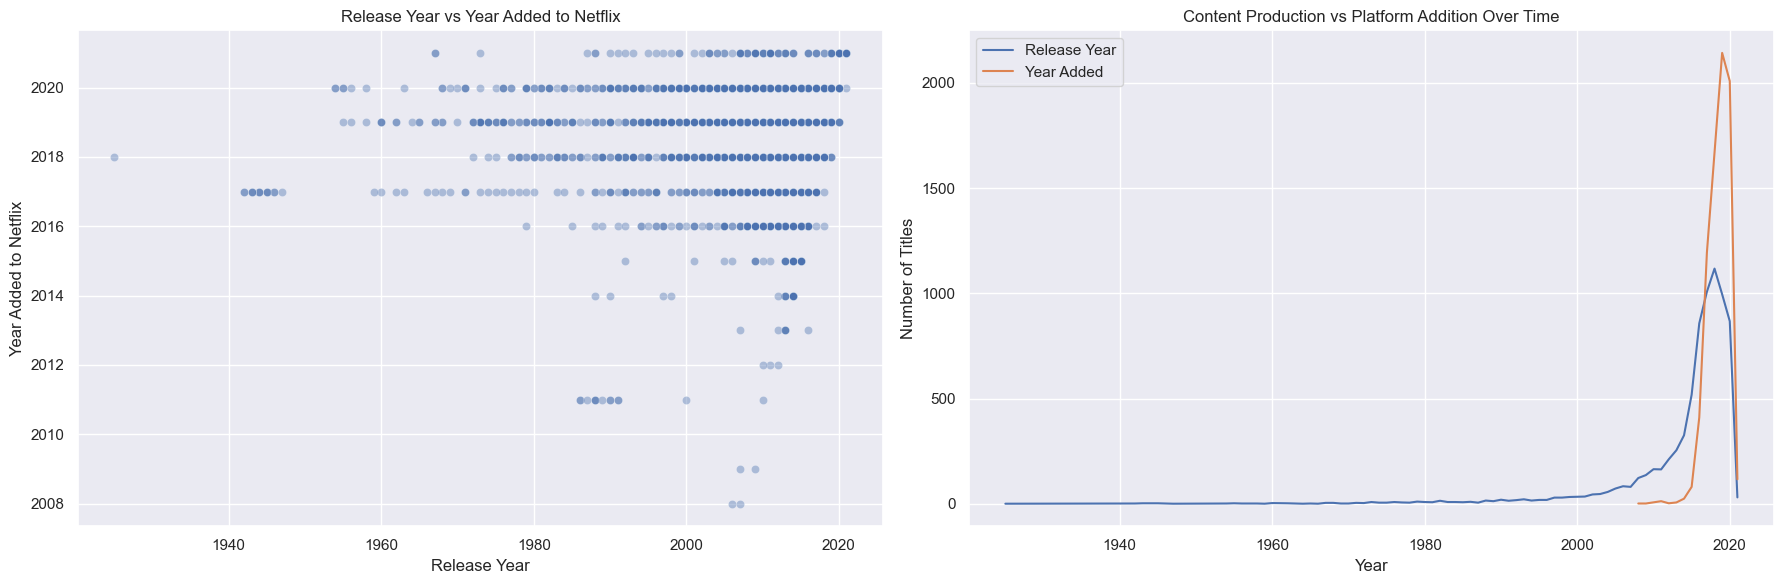

In [73]:

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter Plot: Release Year vs Year Added
sns.scatterplot(
    data=netflix_df,
    x='release_year',
    y='year_added',
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_title('Release Year vs Year Added to Netflix')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Year Added to Netflix')

# Line Plot: Count of titles by year
release_trend = netflix_df['release_year'].value_counts().sort_index()
added_trend = netflix_df['year_added'].value_counts().sort_index()

axes[1].plot(release_trend.index, release_trend.values, label='Release Year')
axes[1].plot(added_trend.index, added_trend.values, label='Year Added')

axes[1].set_title('Content Production vs Platform Addition Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Titles')
axes[1].legend()

plt.tight_layout()
plt.show()


### Release Year vs Year Added Trends

The scatter plot shows a strong alignment between release year and the year content is added to Netflix, indicating faster acquisition of newer titles.
Older content appears less frequently and is added with greater variability, suggesting selective licensing of legacy titles.
The line plot highlights a sharp increase in both content production and platform additions in recent years.
Notably, the gap between release year and year added narrows over time, reflecting Netflix’s shift toward near-real-time content acquisition.
Overall, Netflix increasingly prioritizes fresh content to remain competitive and engagement-focused.


####  What are the most common word pairs or phrases in content descriptions?


In [74]:
from sklearn.feature_extraction.text import CountVectorizer

netflix_df_desc = netflix_df.dropna(subset=['description'])

vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(2, 2),
    max_features=200
)

X = vectorizer.fit_transform(netflix_df_desc['description'])
bigrams = vectorizer.get_feature_names_out()
freqs = X.sum(axis=0).A1

bigram_freq = dict(zip(bigrams, freqs))
movies_desc = netflix_df_desc[netflix_df_desc['type'] == 'Movie']['description']
tv_desc = netflix_df_desc[netflix_df_desc['type'] == 'TV Show']['description']

X_movies = vectorizer.fit_transform(movies_desc)
movies_freq = dict(zip(
    vectorizer.get_feature_names_out(),
    X_movies.sum(axis=0).A1
))

X_tv = vectorizer.fit_transform(tv_desc)
tv_freq = dict(zip(
    vectorizer.get_feature_names_out(),
    X_tv.sum(axis=0).A1
))


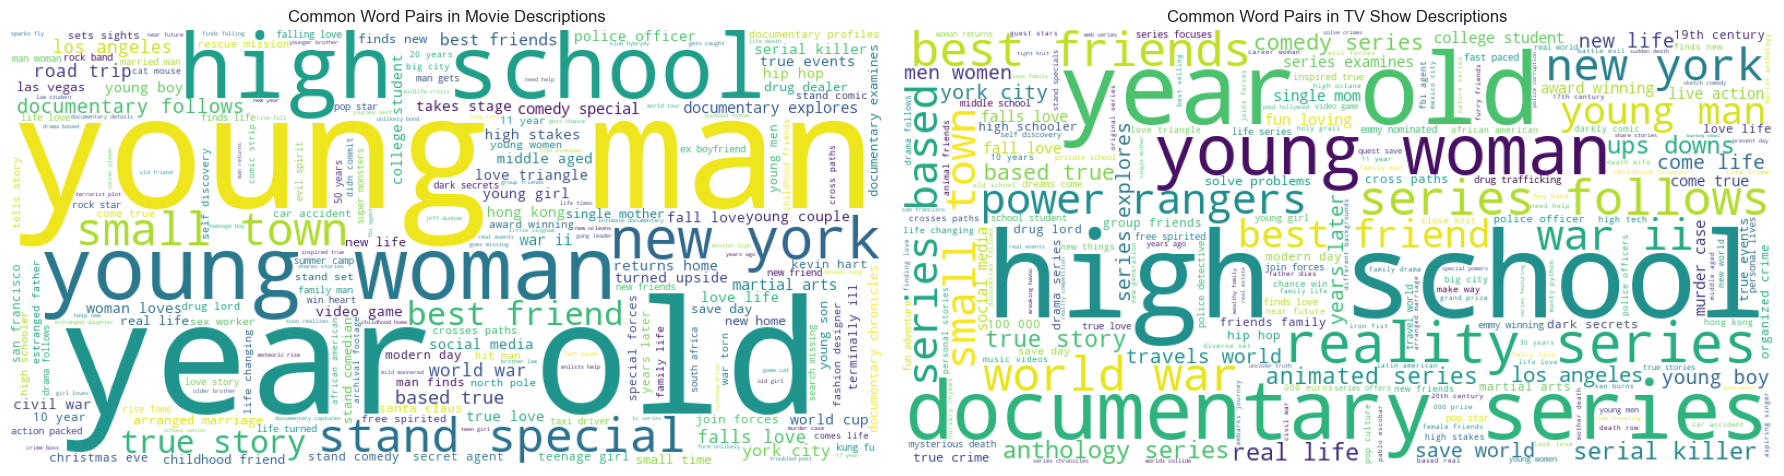

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

wc_movies = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(movies_freq)

axes[0].imshow(wc_movies)
axes[0].set_title('Common Word Pairs in Movie Descriptions')
axes[0].axis('off')

wc_tv = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(tv_freq)

axes[1].imshow(wc_tv)
axes[1].set_title('Common Word Pairs in TV Show Descriptions')
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Common Word Pairs in Content Descriptions

The word clouds reveal dominant recurring themes in Netflix content descriptions, highlighting storytelling elements such as relationships, conflict, and personal journeys.
Movie descriptions emphasize concise, high-impact themes, reflecting standalone narratives.
TV Show descriptions feature word pairs related to long-term character development and evolving story arcs.
The contrast indicates format-driven differences in storytelling language.
Overall, Netflix descriptions consistently focus on emotionally engaging and narrative-driven content.


#### Who are the top directors on Netflix?

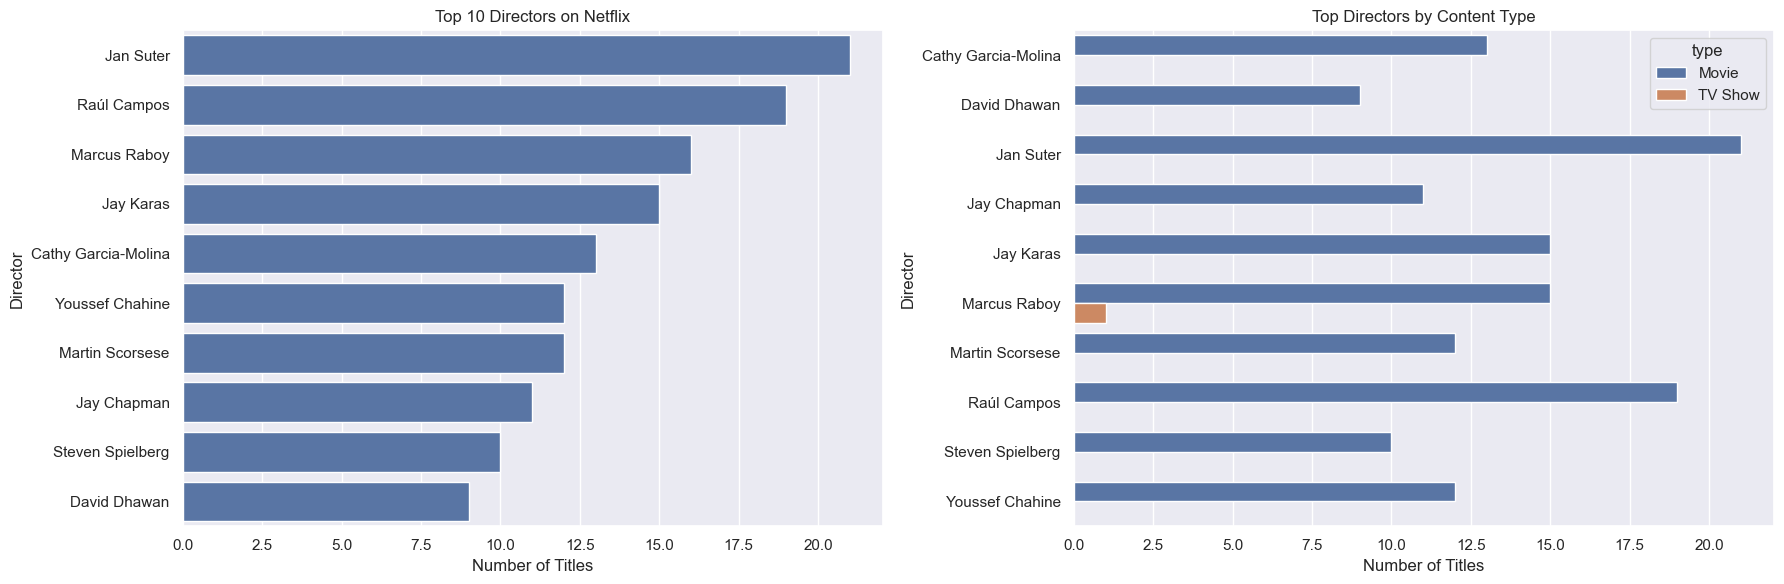

In [76]:
directors_df = netflix_df.dropna(subset=['director']).copy()
directors_df = directors_df[directors_df['director'] != 'Unknown']
directors_df['director'] = directors_df['director'].str.split(', ')
directors_df = directors_df.explode('director')
top_directors = directors_df['director'].value_counts().head(10)
top_directors_df = top_directors.reset_index()
top_directors_df.columns = ['director', 'count']
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: Top directors overall
sns.barplot(
    data=top_directors_df,
    x='count',
    y='director',
    ax=axes[0]
)
axes[0].set_title('Top 10 Directors on Netflix')
axes[0].set_xlabel('Number of Titles')
axes[0].set_ylabel('Director')

# Right: Content type split for top directors
type_split = (
    directors_df[directors_df['director'].isin(top_directors_df['director'])]
    .groupby(['director', 'type'])
    .size()
    .reset_index(name='count')
)

sns.barplot(
    data=type_split,
    x='count',
    y='director',
    hue='type',
    ax=axes[1]
)
axes[1].set_title('Top Directors by Content Type')
axes[1].set_xlabel('Number of Titles')
axes[1].set_ylabel('Director')

plt.tight_layout()
plt.show()

#### Analysis of Top Directors

The analysis filters out unknown entries to reveal the most prolific directors on Netflix. The visualization offers two key perspectives:

1.  **Overall Output (Left Graph):**
    *   **Rajiv Chilaka** emerges as the top contributor, largely driven by his work in animation (e.g., *Chhota Bheem*).
    *   Other top names like **Jan Suter** and **Raúl Campos** appear prominently, known for directing numerous stand-up comedy specials.

2.  **Content Type Strategy (Right Graph):**
    *   There is a clear distinction in specialization. Most top directors focus heavily on either **Movies** or **TV Shows**, rarely balancing both equally.
    *   Directors of comedy specials (often categorized as Movies) and animated series (TV Shows) dominate the list, suggesting that Netflix's highest-volume content creators operate in specific, scalable niches rather than traditional blockbuster filmmaking.